In [48]:
%matplotlib inline
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import training
from chainer.training import extensions

In [8]:
# get dataset
train, test = chainer.datasets.get_mnist(ndim=3)
type(train)

chainer.datasets.tuple_dataset.TupleDataset

In [9]:
len(train), len(test)

(60000, 10000)

In [13]:
type(train[0][0]), type(train[0][1])

(numpy.ndarray, numpy.int32)

In [18]:
train[0][0].shape, train[0][1].shape

((1, 28, 28), ())

In [20]:
train[0][0].dtype, train[0][1].dtype

(dtype('float32'), dtype('int32'))

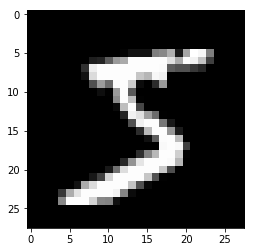

In [31]:
img = train[0][0]
img = np.transpose(img, (1, 2, 0))
plt.imshow(img[:, :, 0], cmap='gray')

In [34]:
class CNN(chainer.Chain):
    def __init__(self, n_mid=100, n_out=10):
        super().__init__()
        with self.init_scope():
            self.cnv1 = L.Convolution2D(in_channels=1, 
                                        out_channels=3, 
                                        ksize=3,
                                        stride=1,
                                        pad=1)
            self.fc1 = L.Linear(None, n_mid)
            self.fco = L.Linear(None, n_out)
            
    def __call__(self, x):
        h = F.relu(self.cnv1(x))
        h = F.max_pooling_2d(h, 3, 3)
        h = self.fc1(h)
        h = self.fco(h)
        return h

In [36]:
# seedの固定
import random

def reset_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    if chainer.cuda.available:
        chainer.cuda.cupy.random.seed(seed)

reset_seed()

In [53]:
batch_size = 4000
epoch = 30
device = 0
gpu_id = 0

# Model Instance
model = L.Classifier(CNN())

# GPUにモデルを転送
model.to_gpu(gpu_id)

# Set Optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

train_iter = chainer.iterators.SerialIterator(train, batch_size)
test_iter = chainer.iterators.SerialIterator(test, batch_size,
                                            repeat=False, shuffle=False)

updater = training.StandardUpdater(train_iter, optimizer, device=device)
trainer = training.Trainer(updater, 
                           (epoch, 'epoch'),
                          out='mnist')

trainer.extend(extensions.Evaluator(test_iter, model, device=device))
trainer.extend(extensions.LogReport(trigger=(1, 'epoch')))
trainer.extend(extensions.PrintReport(['epoch', 'main/accuracy', 'validation/main/accuracy', 'main/loss', 'validation/main/loss', 'elapsed_time']), trigger=(1, 'epoch'))

In [54]:
trainer.run()

epoch       main/accuracy  validation/main/accuracy  main/loss   validation/main/loss  elapsed_time
1           0.436967       0.666667                  2.06245     1.77146               0.697733      
2           0.7068         0.772417                  1.52267     1.22181               1.26117       
3           0.778367       0.82675                   1.03391     0.804275              1.82866       
4           0.8282         0.867417                  0.709371    0.568044              2.39133       
5           0.861583       0.889083                  0.533405    0.445494              2.95198       
6           0.88175        0.90175                   0.438051    0.37734               3.51409       
7           0.892933       0.90825                   0.382081    0.33365               4.07754       
8           0.9013         0.911917                  0.345046    0.303633              4.64008       
9           0.90845        0.918917                  0.317885    0.281123           

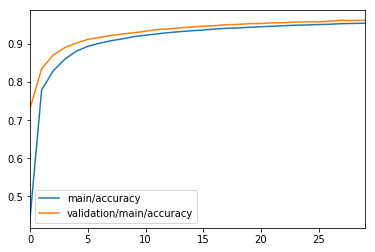

In [51]:
with open('mnist/log') as f:
    result = pd.DataFrame(json.load(f))

result[['main/accuracy', 'validation/main/accuracy']].plot()

In [58]:
# GPUからCPUにモデルを映す
model.to_cpu()

モデルに予測をさせる

True label: 4
Predict label: 4
Predict probalibilty: 0.69452786


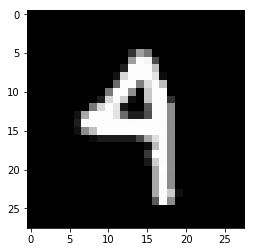

In [85]:
x_sample, t_sample = test[np.random.randint(len(test))]
plt.imshow(x_sample[0, :, :], cmap='gray')
print('True label:', t_sample)

y = model.predictor(np.array([x_sample]))
predict_prob = F.softmax(y).array.max()
predict_y = F.softmax(y).array.argmax()

print('Predict label:', predict_y)
print('Predict probalibilty:', predict_prob)

畳み込みフィルタの確認

In [89]:
W = model.predictor.cnv1.W
type(W)

chainer.variable.Parameter

In [91]:
W.array.shape

(3, 1, 3, 3)

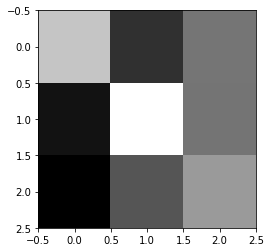

In [104]:
f = W[0, :, :, :]
plt.imshow(f.array[0, :, :], cmap='gray')

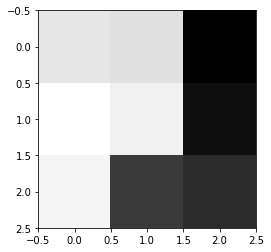

In [103]:
f = W[1, :, :, :]
plt.imshow(f.array[0, :, :], cmap='gray')

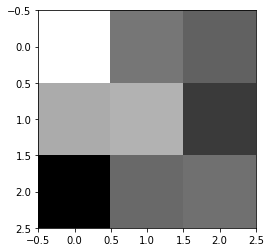

In [105]:
f = W[2, :, :, :]
plt.imshow(f.array[0, :, :], cmap='gray')